In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import os, sys, time
from importlib import reload
%matplotlib inline

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
#from keras_addon import AUCCheckPoint
from utils import get_frequency, preprocess

from ccs_tools import dx_multi, pr_multi, core_dtypes_pd

In [6]:
from ccs_tools import dx_label

## Data Preparation

In [17]:
cohort = 'ami'
tst_seed = 0
DX_rarecutpoint = 100
PR_rarecutpoint = 100
n_fold = 7

In [18]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]
    
folder = 'multi_space_glove/'
all_df = pd.read_csv(path+folder+'cohorts10/{}/pred_comorb.csv'.format(cohort), dtype=core_dtypes_pd)
preprocessed = preprocess(all_df, DX_rarecutpoint=DX_rarecutpoint, PR_rarecutpoint=PR_rarecutpoint)
all_df = preprocessed['int_df']

tst_key = pd.read_csv(path+folder+'cohorts10/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

## convert different variables into different np.array
DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
#los_mean = train_df0['LOS'].mean()
#los_std = train_df0['LOS'].std()

code_mat_tst = tst_df[['DX1']+DXs+PRs].values
code_ohe_tst = np.zeros((len(tst_df), len(code_cat)))
for i in range(code_mat_tst.shape[0]):
    for j in range(code_mat_tst.shape[1]):
        if not code_mat_tst[i,j]==0:
            code_ohe_tst[i, code_mat_tst[i,j]] = 1.

hosp_array_tst = tst_df['HOSP_NRD'].values
hosp_ohe_tst = np.zeros((len(tst_df), len(hosp_cat)))
for j, hosp in enumerate(hosp_array_tst):
    hosp_ohe_tst[j, hosp] = 1.
    
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

other_mat_tst = demo_mat_tst
y_true = tst_df.readm30.astype(int).values

In [19]:
X_tst = np.concatenate([code_ohe_tst, hosp_ohe_tst, other_mat_tst], axis=1)

In [20]:
X_tst.shape, y_true.shape

((20719, 2892), (20719,))

In [21]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)
trn_idx, val_idx = next(skf.split(train_df0, train_df0.HOSP_NRD))

In [22]:
train_df = train_df0.copy()
    
code_mat_train = train_df[['DX1']+DXs+PRs].values
code_ohe_train = np.zeros((len(train_df), len(code_cat)))
for i in range(code_mat_train.shape[0]):
    for j in range(code_mat_train.shape[1]):
        if not code_mat_train[i,j]==0:
            code_ohe_train[i, code_mat_train[i,j]] = 1.
            
#code_ohe_trn = code_ohe_train[trn_idx, :]
#code_ohe_val = code_ohe_train[val_idx, :]
    
hosp_array_train = train_df['HOSP_NRD'].values
hosp_ohe_train = np.zeros((len(train_df), len(hosp_cat)))
for j, hosp in enumerate(hosp_array_train):
    hosp_ohe_train[j, hosp] = 1.
    
#hosp_ohe_trn = hosp_ohe_train[trn_idx, :]
#hosp_ohe_val = hosp_ohe_train[val_idx, :]
    
demo_mat_train = train_df[['AGE', 'FEMALE']].values
demo_mat_train[:, 0] = (demo_mat_train[:, 0]-age_mean)/age_std
other_mat_train = demo_mat_train

#other_mat_trn = other_mat_train[trn_idx, :]
#other_mat_val = other_mat_train[val_idx, :]

y_train = train_df.readm30.astype(int).values
#Y_trn = to_categorical(y_train[trn_idx])
#Y_val = to_categorical(y_train[val_idx])

In [23]:
X_train = np.concatenate([code_ohe_train, hosp_ohe_train, other_mat_train], axis=1)

In [13]:
X_trn = X_train[trn_idx, :]
X_val = X_train[val_idx, :]

y_trn = y_train[trn_idx]
y_val = y_train[val_idx]

In [24]:
X_train.shape, y_train.shape

((181319, 2892), (181319,))

## Model Training and Testing

In [25]:
from xgboost import XGBClassifier

In [26]:
model = XGBClassifier()

In [27]:
start = time.time()
xgb = model.fit(X_train, y_train)
print('It takes {} sec to train.'.format(time.time()-start))

It takes 1634.6824173927307 sec to train.


In [28]:
y_pred = xgb.predict_proba(X_tst)

{0: 0.6918724299755339}

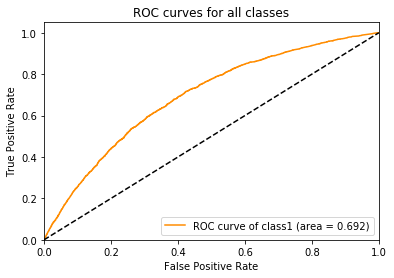

In [29]:
plot_roc(y_pred[:, 1], y_true)